In [20]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Train\\benign',224))
malign_train = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Train\\malignant',224))
benign_test = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Test\\benign',224))
malign_test = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Test\\malignant',224))

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.34it/s]


In [23]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

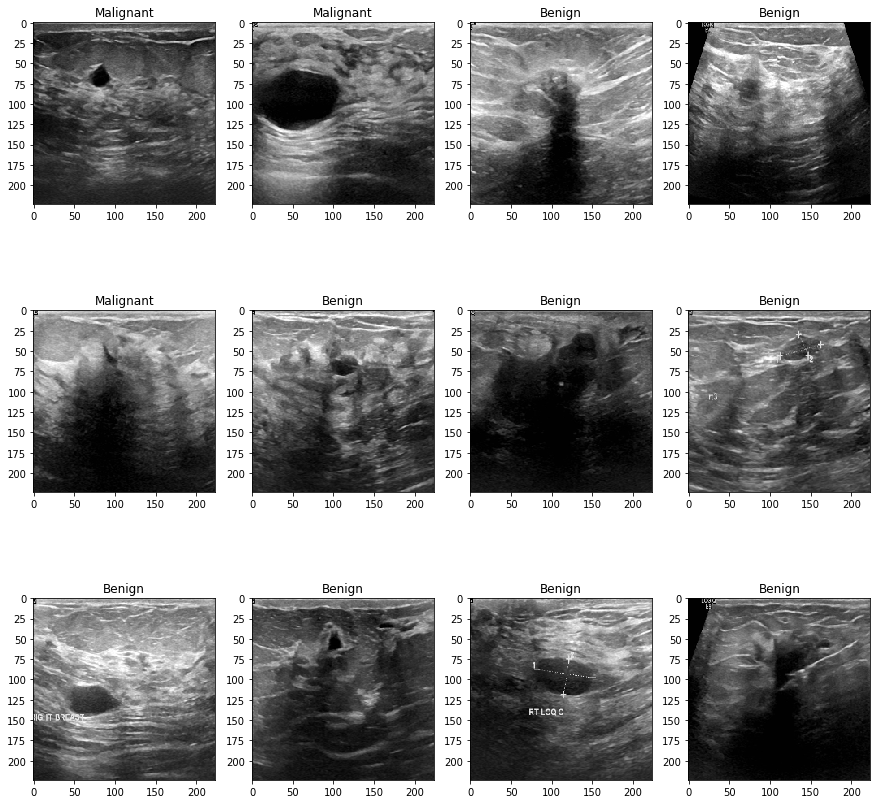

In [24]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [25]:
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [26]:
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions

In [27]:
IMAGE_SIZE = [224, 224]
xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet',pooling = 'avg', include_top=False)

In [28]:
for layer in xception.layers:
  layer.trainable = False

In [29]:
from glob import glob
folders = glob('C:/Users/pauls/Desktop/Dataset_tumor/Train/*')
print(len(folders))

2


In [30]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

y = Flatten()(xception.output)
prediction = Dense(len(folders), activation='softmax')(y)
model = Model(inputs=xception.input, outputs=prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [31]:
from tensorflow.keras.optimizers import Adam

adam = Adam()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
model_history = model.fit(x_train, y_train,
          batch_size=10,
          epochs=10,
          verbose=1,
          validation_data=(x_val,y_val))

Epoch 1/10
182/182 [==============================] - 165s 856ms/step - loss: 1.1825 - accuracy: 0.6480 - val_loss: 0.6561 - val_accuracy: 0.7807
Epoch 2/10
182/182 [==============================] - 161s 883ms/step - loss: 0.5157 - accuracy: 0.7734 - val_loss: 0.4275 - val_accuracy: 0.8399
Epoch 3/10
182/182 [==============================] - 167s 919ms/step - loss: 0.3982 - accuracy: 0.8293 - val_loss: 0.6400 - val_accuracy: 0.7566
Epoch 4/10
182/182 [==============================] - 170s 935ms/step - loss: 0.4610 - accuracy: 0.8118 - val_loss: 0.2951 - val_accuracy: 0.8991
Epoch 5/10
182/182 [==============================] - 169s 927ms/step - loss: 0.2834 - accuracy: 0.8999 - val_loss: 0.2893 - val_accuracy: 0.8991
Epoch 6/10
182/182 [==============================] - 169s 932ms/step - loss: 0.2783 - accuracy: 0.9031 - val_loss: 0.2469 - val_accuracy: 0.9189
Epoch 7/10
182/182 [==============================] - 170s 936ms/step - loss: 0.2201 - accuracy: 0.9248 - val_loss: 0.2836 -

In [33]:
Y_pred = model.predict(X_test, steps=1,verbose =2)

1/1 - 18s


Confusion matrix, without normalization
[[123   3]
 [ 13  38]]


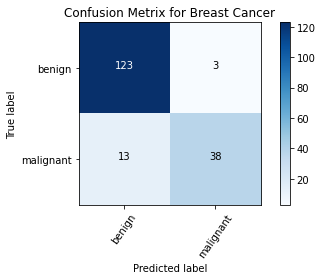

In [34]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')